In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib widget

data_path = 'data/'
train_lidar_path = data_path + 'train_lidar/'
train_labels_path = data_path + 'train_infos/'

classes = {
    'Car': 0,
    'Truck': 1,
    'Bus': 2,
    'Pedestrian': 3,
    'Cyclist': 4
}

class_colors = {
    'Car': 'blue',
    'Truck': 'red',
    'Bus': 'green',
    'Pedestrian': 'magenta',
    'Cyclist': 'cyan'
}

[[-1.4664810e+00  8.9188538e+01  4.6170454e+00  1.1000000e-01]
 [-1.2718700e+00  7.7352669e+01  2.6353395e+00  9.9999998e-03]
 [ 4.2668800e+00  7.5725891e+01  2.1331437e+00  1.1000000e-01]
 ...
 [-1.4359695e-01  7.2035260e+00 -1.6701518e+00  3.9999999e-02]
 [-1.3412625e-01  6.7284298e+00 -1.6787925e+00  3.8999999e-01]
 [-1.4453445e-02  7.2505552e-01 -3.3776557e-01  0.0000000e+00]]


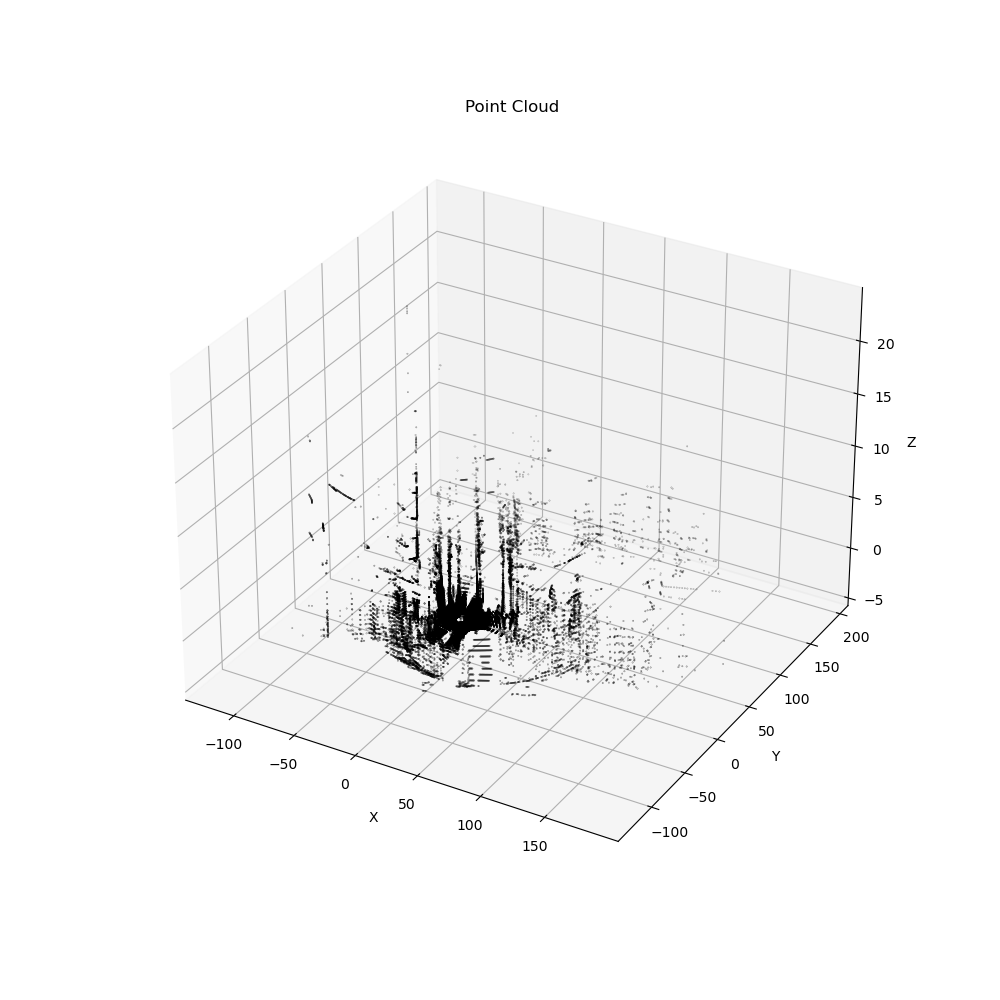

In [2]:
fbin = train_lidar_path + "data/000076/lidar_roof/1616343527200.bin"


point_cloud = np.fromfile(fbin, dtype=np.float32).reshape(-1, 4)
print(point_cloud)

# plot the point cloud in 3D
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 10))

ax.scatter3D(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.05, c='black')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud')
plt.show()

Car


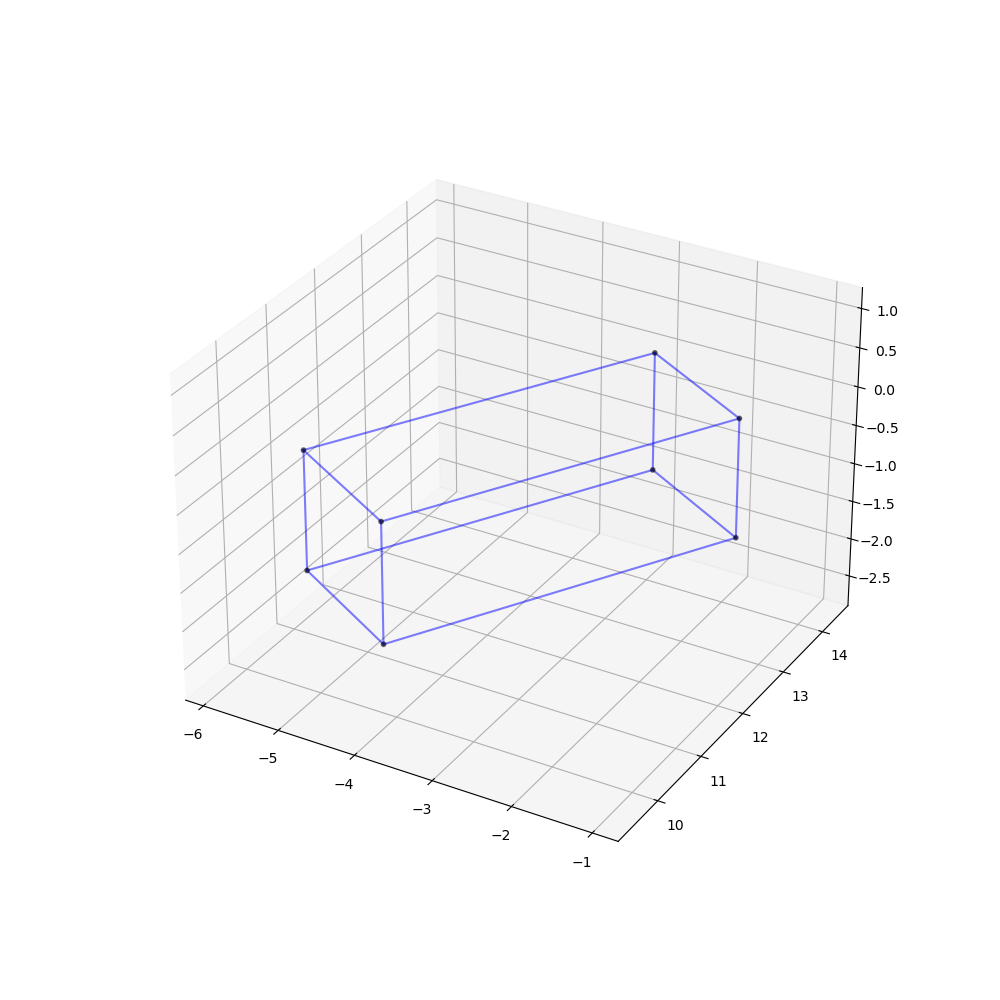

In [8]:
# Read labels from json
flabels = train_labels_path + "data/000076/000076.json"

with open(flabels) as f:
    labels = json.load(f)

annotations = labels["frames"][0]["annos"]
# print(annotations)

box_class = annotations["names"][0]
print(box_class)
box = annotations["boxes_3d"][0]

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 10))

# equal axis ratio


# center_x, center_y, center_z, l, w, h, yaw

# find the corners of the box
center_x, center_y, center_z, l, w, h, yaw = box

corners_x = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]]).T
corners_y = np.array([[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]]).T
corners_z = np.array([[h/2, h/2, h/2, h/2, -h/2, -h/2, -h/2, -h/2]]).T
points = np.hstack((corners_x, corners_y, corners_z))

# print(points)

# ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], s=10, c='red', alpha=0.5)

# rotation matrix
R = np.array([[np.cos(yaw), -np.sin(yaw), 0],
              [np.sin(yaw),  np.cos(yaw), 0],
              [          0,            0, 1]])
# rotate the box
points = points @ R

# ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], s=10, c='green', alpha=0.5)

# offset the box with center position
points[:, 0] += center_x
points[:, 1] += center_y
points[:, 2] += center_z

point_c = "black"
line_c = class_colors[box_class]

# plot the points
ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], s=10, c=point_c, alpha=0.5)

# plot 12 lines of bounding box
for i in range(4):
    ax.plot3D(points[[i, i+4], 0], points[[i, i+4], 1], points[[i, i+4], 2], c=line_c, alpha=0.5)
for i in range(4):
    ax.plot3D(points[[i, (i+1)%4], 0], points[[i, (i+1)%4], 1], points[[i, (i+1)%4], 2], c=line_c, alpha=0.5)
for i in range(4):
    ax.plot3D(points[[i+4, (i+1)%4+4], 0], points[[i+4, (i+1)%4+4], 1], points[[i+4, (i+1)%4+4], 2], c=line_c, alpha=0.5)

ax.set_aspect('equal', adjustable='box')